In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [36]:
inpDir = os.path.join( '..', 'input')


###moduleDir = 'MACHINE LEARNING'

outDir = os.path.join('output')
subDir = 'fashion_mnist'

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

ALPHA = 0.001     # learning rate
EPOCHS = 30
BATCH_SIZE = 64


# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE=0.2

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

<Figure size 1500x600 with 0 Axes>

### Prevent Tensorflow from hogging the memory

In [6]:
train_df=pd.read_csv(os.path.join(inpDir, 'fashion-mnist_train.csv'))
test_df=pd.read_csv(os.path.join(inpDir, 'fashion-mnist_test.csv'))

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,...,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,...,0,0,0,0
1,9,0,0,0,...,0,0,0,0
2,6,0,0,0,...,0,0,0,0
3,0,0,0,0,...,0,0,0,0
4,3,0,0,0,...,0,0,0,0


In [8]:
test_df.head()

,label,pixel1,pixel2,pixel3,...,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,...,0,0,0,0
1,1,0,0,0,...,0,0,0,0
2,2,0,0,0,...,31,0,0,0
3,2,0,0,0,...,222,56,0,0
4,3,0,0,0,...,0,0,0,0


In [9]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [10]:
train_df.shape , test_df.shape

((60000, 785), (10000, 785))

In [11]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [12]:
test_df['label'].unique()

array([0, 1, 2, 3, 8, 6, 5, 4, 7, 9], dtype=int64)

In [13]:
train_df.max()

label         9
pixel1       16
pixel2       36
pixel3      226
pixel4      164
           ... 
pixel780    255
pixel781    255
pixel782    255
pixel783    255
pixel784    170
Length: 785, dtype: int64

In [14]:
train_df.min()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

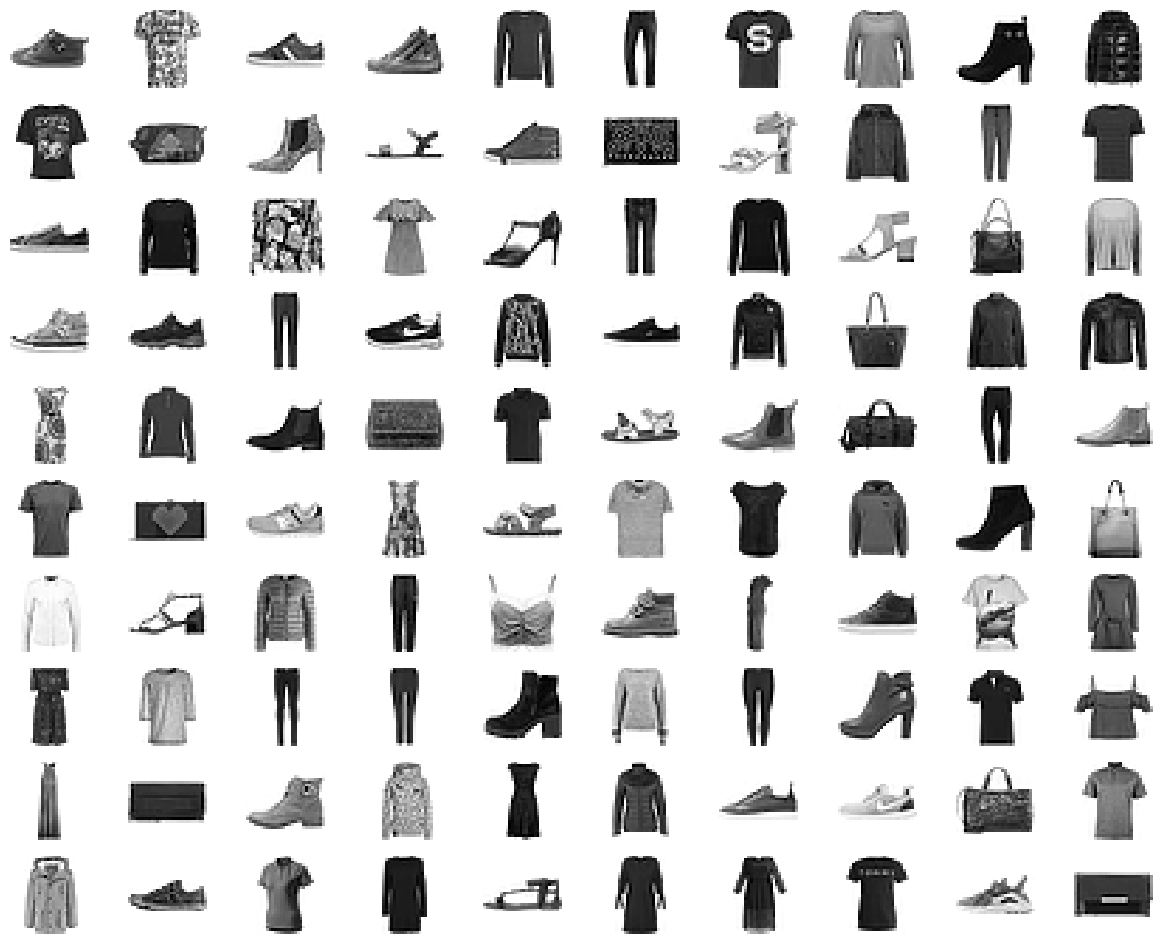

In [15]:
plot_df = train_df.sample(n = 100) # sample 100
fig = plt.figure(figsize = (15,12))
i = 0
for _, row in plot_df.iterrows():
    i += 1

    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(10,10,(i),xticks=[],yticks=[])

    ax.imshow(image, cmap=plt.cm.binary)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [17]:
train_df

,label,pixel1,pixel2,pixel3,...,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,...,0,0,0,0
1,9,0,0,0,...,0,0,0,0
2,6,0,0,0,...,0,0,0,0
3,0,0,0,0,...,0,0,0,0
4,3,0,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,...,0,0,0,0
59996,1,0,0,0,...,0,0,0,0
59997,8,0,0,0,...,0,0,0,0
59998,8,0,0,0,...,0,0,0,0


In [18]:
features_df = train_df.drop('label',axis =1)
labels =train_df['label']

In [19]:
labels.value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

In [20]:
labels = pd.get_dummies(labels)

In [21]:
X_train, X_test, y_train,y_test = train_test_split(features_df,labels,
                                                   test_size=TEST_SIZE, 
                                                   stratify=labels, 
                                                   random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape,y_test.shape 

((48000, 784), (12000, 784), (48000, 10), (12000, 10))

In [22]:
cols = train_df.columns

for col in cols:
    print(f'\nColumns Name: {col} : {train_df[col].unique()}')


Columns Name: label : [2 9 6 0 3 4 5 8 7 1]

Columns Name: pixel1 : [ 0 14  7  3 16  1  4  2]

Columns Name: pixel2 : [ 0  1  3 10  6  2  7  5 16 14 13  9 34 15  4 11 36]

Columns Name: pixel3 : [  0   2   1  10   3   6   4   5   7  56  34  32  16  14  78  25  13   9
   8  52  35  30  23  54 226  15 106]

Columns Name: pixel4 : [  0   1   5   2   3  20  46  87   4  16  12   6  64  36  52  13   7 164
 110  14  92 106 120 105  53  70   9  23  49  25  26  34 121  21  17  10
  41  18  28  80  56 144  22  54  55  50  90 150  19 109  83 132  48  11
  32 145  39  96  15  58   8  68  82 146  86]

Columns Name: pixel5 : [  0   2   4   1   5   3  26  14  39  62  15  16  84   7  88  41  65  17
  35  61  11  21  10   6  18 119 162 106  34  12 217  33  24  37  13 185
  38  71  73   9  40  56  68 171  89  97  91  23  59  42  77 103  29 148
 140  31  45 201   8  95 133  80  44  43  27  20  32  58 123  22 116  66
  60  53 145  85 100  54 210 166 113  19  28 227  30  51  64  96  75  70
  90  82 115 15


Columns Name: pixel267 : [209   0 210  93 222 155 219 214   1 220 110  66 131 112 246 235 225  91
  65 160 156 206 177 181 106 123 152  73 234 101 157 232 215 216  39 242
 137 100 130 120  62 111 228  35 179 248  95 193 114 212  27 207 113 244
 171   2 146 144 194 150  77  44 186 169  84 102  76 199 255 164 119 132
 109 124 153 127 227  28  98 147   8 226 236 134 240 189 105  23  60   7
  47 203 143 183  57 126 104  56 107  55 195  54  70 142 254 200 204 192
 190 249  43 223 241 174  86 125 239 201 205  12   6  64 187 208 141 116
 129 188 191  75 162 218  83 217 231  90 172  96 198 184 165 178  88  80
 175  37  19  34 243 197  74 159 168 229  67 224 196 230 176 136 237  48
  22 158 170  92  97 163  53  72  20 161 233  94  45  36 167 117  49 211
  38 173   3 202   5  81  79 166 118  78  82 247 238  30  51  14 121 115
 138  42 151 213   9  40  15 180 122 145  50  68 185  87  10 128  17  59
 182  13  69  24 148 103  71 139  85 135  26  16 108  31 250   4 221 154
  25  58  46 133  32  21 


Columns Name: pixel516 : [202 152 203 113 220 110 228   0 208 156 218  31 116 200 120 194 236 230
 199 177  68 100 149 192 169 178 184  46 235 137 198 231  69 239 163  35
 209 214  74 255 147 123 176 124 191  42 144   3 104 229 207 193 151 237
 102 188 175 111  27 234 213 232 179 172 212 180 155 129 211  81 183 168
 167 187 150  93 164  10  77 122   1 130  50 128  98 205 121 227 158 195
 210  52 103 166  73  95  96  51 238 225 224  89  99 127 171  88  41  97
 247 138 159 222  60 143  26  67 251 146 245 139 221 115 249 243 248  65
  61  57 185  23  83  63  30 148 196  72  24 132 133 117 145 165 170 204
 160 219 162 240  86 109 241 126 107  40 244 186 134 108 190 114  36  43
 233 206 157  28 197  76 182 106   2 173  90 189 226 153 223  59  71  17
 154 201 161  13  53  70 118  84 141 217  45 142 140  87 125 105  34 216
 131  58  12  38  75 215  21  33 174 136 252  82  62  37  39  49  29  78
  44  19  55  80 112  94   6 242  54   9 181 253  18  22 135 101  47  92
 119   8  56  91  79 246 


Columns Name: pixel773 : [  0 165  74 102  12  48   7 189 172  11  10 151  73 118  98 129   5 127
  35 244 167  79 248 126 108  46 114 103 111   1 184   3 216  69 192 105
  96 109 166  14 125 116 183 101 135  82  55 171 150 117 154 162 195 144
  62 130 157 149  34   9 132  94  93 226  97 139 175 240  51  95  60  59
  92  63 203 122  77 176  45  72 212  78 142 153 123 148 208  21 152 106
  53   2  83  42 113  85 156 133 186  64 224 204 174 143  84  61  43 234
 147  16 206 155  26 196  68   4  28 119 141 197 190  37 201 140  54  58
 193 115 161  13 137 180 182 134 104  80  36 185 209 187  87  44 120 107
 177  57 112 194  88  15 222  29  75  89 211  31  70  27  47 160  65  23
 138  52  33  56 198 146  67  30  25 179  76 136 145  32 221 218 220 188
 131 121 227  40   6 169 210  41 170 191  19 100 163  91 230 110 178 158
  81 225 159  86  49  50  71 213 215  38 173 202 217 168  22 214 231 124
  20  17  66  99 164 205 241  18  90 243  39   8 128 181 207 223 200 249
 238 233 228 235 229  24 

In [37]:
sc  = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [38]:
torch.cuda.current_device()

0

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [40]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 2060 SUPER'

In [41]:
input_dim = X_train.shape[1] # number of cols in features

model = nn.Sequential(nn.Linear(input_dim,397),
                      nn.Tanh(),
                      nn.Linear(397,10))
                     
model = model.to(device)

In [42]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=397, bias=True)
  (1): Tanh()
  (2): Linear(in_features=397, out_features=10, bias=True)
)


In [43]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0202,  0.0209, -0.0007,  ...,  0.0111,  0.0259, -0.0181],
         [ 0.0266,  0.0233, -0.0285,  ..., -0.0215, -0.0162,  0.0072],
         [-0.0102,  0.0185, -0.0028,  ..., -0.0309, -0.0056, -0.0027],
         ...,
         [ 0.0237, -0.0111,  0.0332,  ...,  0.0312,  0.0032, -0.0267],
         [-0.0031, -0.0037,  0.0294,  ...,  0.0059, -0.0067,  0.0184],
         [-0.0263,  0.0221, -0.0152,  ..., -0.0141, -0.0258, -0.0289]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-2.3159e-02,  2.0281e-02,  7.8215e-03,  2.0732e-02,  1.8271e-02,
         -2.8449e-02, -3.1856e-02,  7.4705e-03, -2.9144e-02,  1.3268e-02,
          1.2498e-02, -2.9600e-02, -4.4285e-03,  9.4400e-03,  2.0105e-02,
          2.9386e-02,  1.7024e-02,  3.3198e-02,  1.6888e-02,  6.7818e-03,
         -1.5728e-02, -1.1385e-02,  1.2348e-02, -4.9501e-03,  2.3444e-02,
         -2.7717e-02,  5.7036e-03,  3.8417e-03, -9.6048e-03,  3.3740e-02,
         -3.4492e-02, -

In [44]:
print(f'Number of parameter: {len(list(model.parameters()))}')

Number of parameter: 4


In [45]:
print(f'Layer 1 Weights: {list(model.parameters())[0].shape}')
print(f'Layer 1 bias   : {list(model.parameters())[1].shape}')
print(f'Layer 2 Weights: {list(model.parameters())[2].shape}')
print(f'Layer 2 bias   : {list(model.parameters())[3].shape}')

Layer 1 Weights: torch.Size([397, 784])
Layer 1 bias   : torch.Size([397])
Layer 2 Weights: torch.Size([10, 397])
Layer 2 bias   : torch.Size([10])


In [46]:
train_X = Variable(torch.Tensor(X_train)).to(device)
test_X = Variable(torch.Tensor(X_test)).to(device)
train_y = Variable(torch.Tensor(y_train.to_numpy())).to(device)
test_y = Variable(torch.Tensor(y_test.to_numpy())).to(device)

In [47]:
# predict.shape,train_y.shape

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),weight_decay=0.001)


loss, tloss, n_epoch, acc, tacc= [],[],[],[],[]

for epoch in range(EPOCHS):
    model.train() # set ur model in train mode
    
    predict = model(train_X) # make prediction

    curr_loss = loss_fn(predict,train_y) # calculate loss
    
   ########################## 
   ### Back Propagation #####
   ##########################
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    
    loss.append(curr_loss.data.item())
    
    _, y_pred = torch.max(predict, 1)
    
    curr_acc = accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())
    
    acc.append(curr_acc)
    
    model.eval() # dont update weights
    
    predict_tst = model(test_X) # MAKE PREDICTION
    
    curr_loss_tst = loss_fn(predict_tst, test_y)  # Calculate loss
    
    tloss.append(curr_loss_tst.data.item())
    
    _, y_pred = torch.max(predict, 1)
    
    curr_acc_tst = accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())

    tacc.append(curr_acc_tst)
    
    n_epoch.append(epoch)

In [49]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss': loss,
                       'test loss' : tloss,
                       'acc':acc,
                       'test acc': tacc
                       })
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,2.28,1.50,0.11,0.11
1,1,1.50,1.16,0.59,0.59
2,2,1.15,0.99,0.65,0.65
3,3,0.98,0.89,0.68,0.68
4,4,0.88,0.82,0.70,0.70


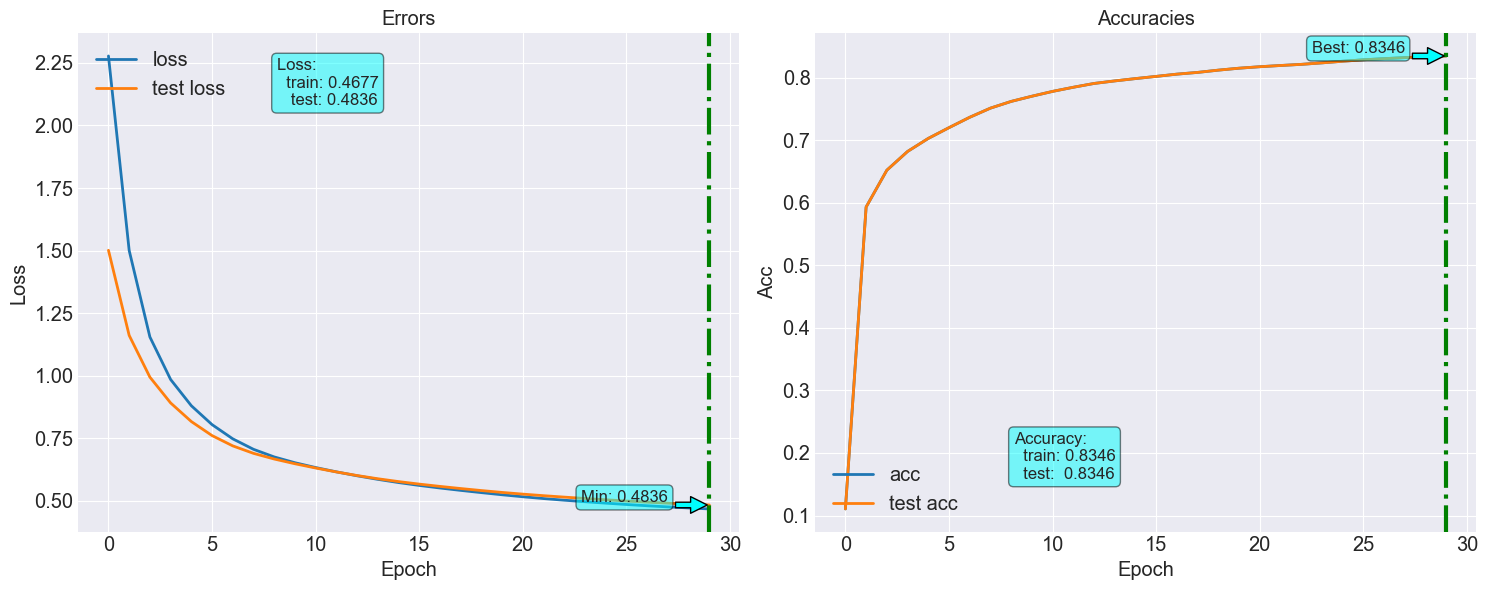

In [50]:
fn_plot_torch_hist(loss_df)

In [51]:
predict = model(train_X)

_, y_pred = torch.max(predict, 1)

accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())


0.8357916666666667

In [52]:
predict = model(test_X)

_, y_pred = torch.max(predict, 1)

accuracy_score(y_test.to_numpy().argmax(axis=1),y_pred.data.cpu())

0.8320833333333333